In [1]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [3]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [4]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [5]:
start = pd.Timestamp('2010-01-01')
end = pd.Timestamp('2020-03-24')

apollo = web.DataReader('APOLLOHOSP.NS', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

apollo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2519 entries, 2010-01-04 to 2020-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2519 non-null   float64
 1   Low        2519 non-null   float64
 2   Open       2519 non-null   float64
 3   Close      2519 non-null   float64
 4   Volume     2519 non-null   float64
 5   Adj Close  2519 non-null   float64
dtypes: float64(6)
memory usage: 137.8 KB


In [6]:
apollo.head()

High         Low        Open       Close    Volume  \
Date                                                                   
2010-01-04  362.500000  323.600006  327.000000  347.149994  563604.0   
2010-01-05  370.000000  342.549988  349.450012  366.375000  597476.0   
2010-01-06  367.100006  325.625000  325.625000  353.924988  168942.0   
2010-01-07  374.500000  340.000000  340.000000  356.924988  392410.0   
2010-01-08  367.000000  352.500000  359.500000  355.725006  133122.0   

             Adj Close  
Date                    
2010-01-04  326.831299  
2010-01-05  344.931152  
2010-01-06  333.209778  
2010-01-07  336.034210  
2010-01-08  334.904510

In [7]:
hurst(apollo)

array([0.31817295, 0.29975787, 0.30216218, 0.30567139, 0.01741642,
       0.3051574 ])

In [8]:
# Calculate daily returns as percentage price changes
apollo['Return'] = 100 * (apollo['Close'].pct_change())
apollo['Log_Return'] = np.log(apollo['Close']).diff().mul(100) # rescale to faciliate optimization
apollo = apollo.dropna()

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(apollo['Log_Return'], lags=100, title='Apollo Hospitals Enterprise Cipla Log Return')

In [9]:
plot_correlogram(apollo['Log_Return'].sub(apollo['Log_Return'].mean()).pow(2), lags=100, title='Apollo Hospitals Enterprise Daily Volatility')

In [10]:
# Calculate daily std of returns
std_daily = apollo['Return'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 2.08%

Monthly volatility: 9.51%

Annual volatility: 32.95%


In [11]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance

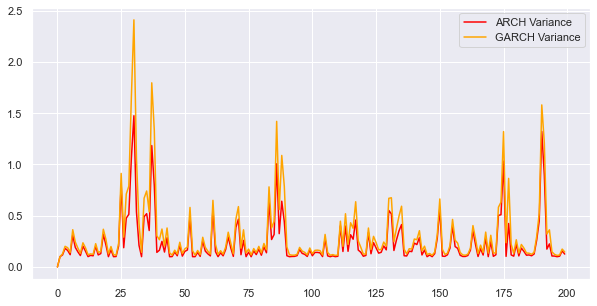

In [12]:
# Simulate a ARCH(1) series
arch_resid, arch_variance = simulate_GARCH(n= 200, 
                                           omega = 0.1, alpha = 0.7)
# Simulate a GARCH(1,1) series
garch_resid, garch_variance = simulate_GARCH(n= 200, 
                                             omega = 0.1, alpha = 0.7, 
                                             beta = 0.1)

# Plot the ARCH variance
plt.figure(figsize=(10,5))
plt.plot(arch_variance, color = 'red', label = 'ARCH Variance')

# Plot the GARCH variance
plt.plot(garch_variance, color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()

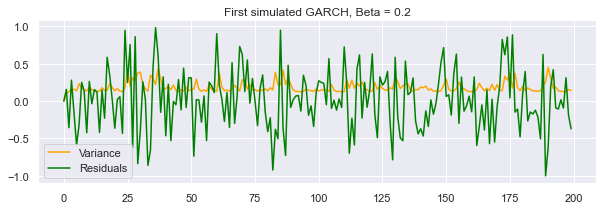

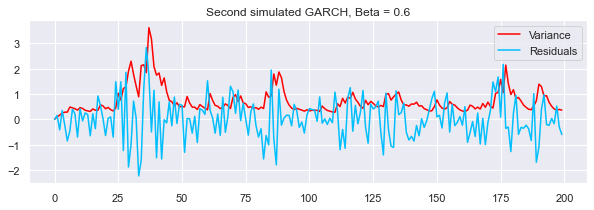

In [13]:
# First simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.2)
plt.plot(sim_variance, color = 'orange', label = 'Variance')
plt.plot(sim_resid, color = 'green', label = 'Residuals')
plt.title('First simulated GARCH, Beta = 0.2')
plt.legend(loc='best')
plt.show()

# Second simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Variance')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals')
plt.title('Second simulated GARCH, Beta = 0.6')
plt.legend(loc='best')
plt.show()

In [14]:
# Specify GARCH model assumptions
basic_gm = arch_model(apollo['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     30,   Neg. LLF: 5523.857495212591
Iteration:      8,   Func. Count:     52,   Neg. LLF: 5231.32937036918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5231.32937036918
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


In [15]:
# Display model fitting summary
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5231.33
Distribution:                  Normal   AIC:                           10470.7
Method:            Maximum Likelihood   BIC:                           10494.0
                                        No. Observations:                 2518
Date:                Thu, Mar 25 2021   Df Residuals:                     2517
Time:                        19:23:10   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0837  3.763e-02      2.223  2.623e-02 [9.893e-0

In [16]:
# Plot fitted results
gm_result.plot()
plt.show()

In [17]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                  h.1        h.2        h.3       h.4        h.5
Date                                                            
2020-03-24  57.199962  49.434716  42.811346  37.16194  32.343276


In [18]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

In [19]:
# Specify GARCH model assumptions
skewt_gm = arch_model(apollo['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

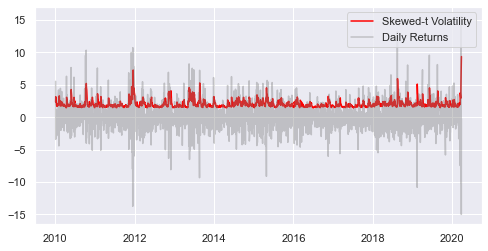

In [20]:
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(apollo['Return'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

In [21]:
import pmdarima as pm

model = pm.auto_arima(apollo['Log_Return'],

d=0, # non-seasonal difference order
start_p=1, # initial guess for p
start_q=1, # initial guess for q
max_p=4, # max value of p to test
max_q=4, # max value of q to test                        
                    
seasonal=False, # is the time series seasonal
                    
information_criterion='bic', # used to select best model
trace=True, # print results whilst training
error_action='ignore', # ignore orders that don't work
stepwise=True, # apply intelligent order search
                        
)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=10825.666, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=10822.420, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=10830.203, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=10830.197, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=10828.912, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.532 seconds


In [22]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2518
Model:                        SARIMAX   Log Likelihood               -5407.294
Date:                Thu, 25 Mar 2021   AIC                          10816.589
Time:                        19:23:42   BIC                          10822.420
Sample:                             0   HQIC                         10818.705
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.2932      0.059     72.461      0.000       4.177       4.409
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              4223.72
Prob(Q):                              0.81   Pr

In [23]:
# Fit best model
_arma_model = sm.tsa.SARIMAX(endog=apollo['Log_Return'],order=(0, 0, 1))
_model_result = _arma_model.fit()

In [24]:
# Plot model residuals
_model_result.plot_diagnostics(figsize=(10, 5))
plt.show()

In [25]:
# Fit GARCH model with ARMA model residuals
_garch_model = arch_model(_model_result.resid, mean='Zero', p=1, q=1)
_garch_result = _garch_model.fit(disp = 'off')
print(_garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5221.29
Distribution:                  Normal   AIC:                           10448.6
Method:            Maximum Likelihood   BIC:                           10466.1
                                        No. Observations:                 2518
Date:                Thu, Mar 25 2021   Df Residuals:                     2518
Time:                        19:23:53   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6260      0.173      3.615  3.003e-04 [  0.287,  0.96

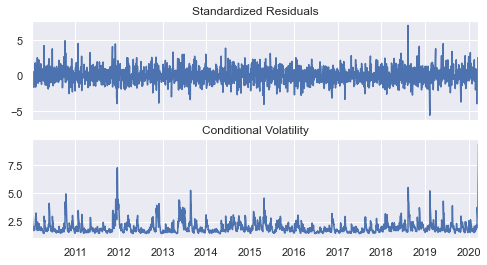

In [26]:
# Plot GARCH model fitted results
_garch_result.plot()
plt.show()

In [27]:
plot_correlogram(_garch_result.resid.dropna(), lags=100, title='Apollo Hospitals Enterprise GARCH Residuals')

In [30]:
bitcoin_data = pd.read_csv('https://api.blockchain.info/charts/market-price?start=2010-10-09&timespan=12years&format=csv', 
                         names=['Timestamp','Close'], index_col='Timestamp')
bitcoin_data.index = pd.to_datetime(bitcoin_data.index, format='%Y-%m-%d')
bitcoin_data = bitcoin_data.loc[(bitcoin_data != 0.0).any(axis=1)]
bitcoin_data['Return'] = np.log(bitcoin_data['Close']).diff().mul(100) # rescale to faciliate optimization
bitcoin_data = bitcoin_data.dropna()
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1269 entries, 2010-10-12 to 2021-03-12
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1269 non-null   float64
 1   Return  1269 non-null   float64
dtypes: float64(2)
memory usage: 29.7 KB


In [31]:
# Plot bitcoin price data 
fig, ax1 = plt.subplots(figsize=(13, 5))
ax1.set_yscale('log')
ax1.plot(bitcoin_data.index, bitcoin_data.Close, color='b', label='BTCUSD')
ax1.set_xlabel('Date')
ax1.set_ylabel('BTCUSD Close')
ax1.legend()
plt.show()

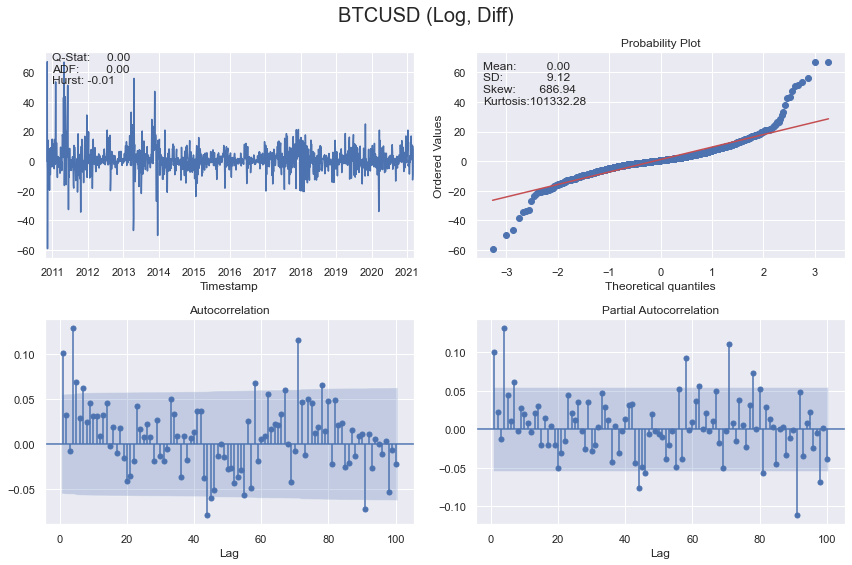

In [32]:
plot_correlogram(bitcoin_data['Return'], lags=100, title='BTCUSD (Log, Diff)')

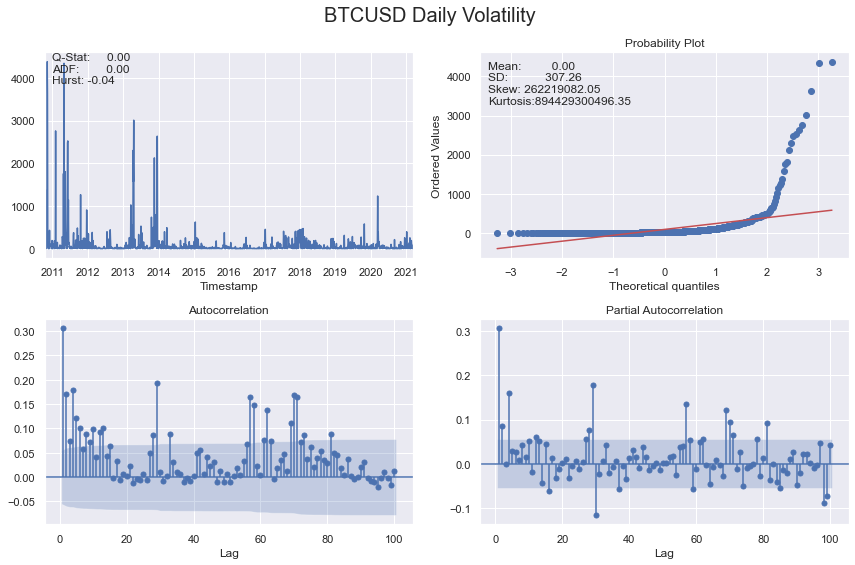

In [33]:
plot_correlogram(bitcoin_data['Return'].sub(bitcoin_data['Return'].mean()).pow(2), lags=100, title='BTCUSD Daily Volatility')

In [34]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -4220.84
Distribution:      Standardized Student's t   AIC:                           8453.67
Method:                  Maximum Likelihood   BIC:                           8484.55
                                              No. Observations:                 1269
Date:                      Fri, Mar 12 2021   Df Residuals:                     1268
Time:                              14:48:43   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

In [35]:
# Specify EGARCH model assumptions
egarch_gm = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -4214.67
Distribution:      Standardized Student's t   AIC:                           8441.34
Method:                  Maximum Likelihood   BIC:                           8472.22
                                              No. Observations:                 1269
Date:                      Fri, Mar 12 2021   Df Residuals:                     1268
Time:                              14:49:04   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

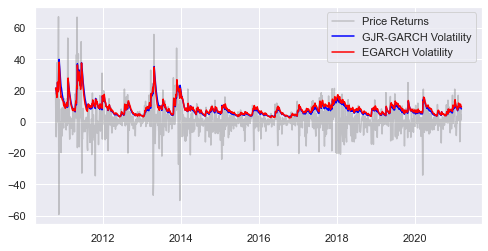

In [36]:
gjrgm_vol = gjrgm_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility

# Plot the actual Bitcoin returns
plt.plot(bitcoin_data['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [37]:
# Print each models BIC
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'\nEGARCH BIC: {egarch_result.bic}')

GJR-GARCH BIC: 8484.546876500048

EGARCH BIC: 8472.217450763888


In [38]:
index = sp_data.index
start_loc = 0
end_loc = np.where(index >= '2020-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_fixedwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


In [39]:
index = sp_data.index
start_loc = 0
end_loc = np.where(index >= '2020-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_expandwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


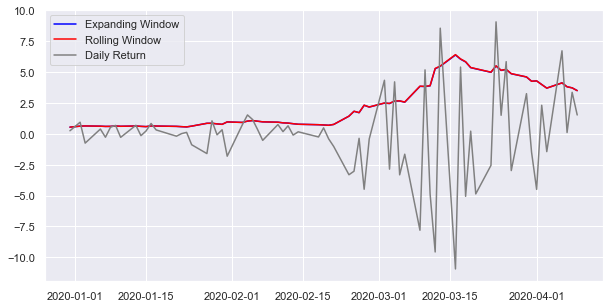

In [40]:
# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin)

# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin)

# Plot results
plt.figure(figsize=(10,5))

# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue', label='Expanding Window')

# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red', label='Rolling Window')

plt.plot(sp_data.Return.loc[variance_expandwin.index], color = 'grey', label='Daily Return')

plt.legend()
plt.show()

In [41]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

          parameter       p-value
mu         0.071852  1.476369e-09
omega      0.026798  4.184451e-06
alpha[1]   0.141385  6.518906e-19
beta[1]    0.837217  0.000000e+00


In [42]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'std-err': gm_result.std_err, 
                             't-value': gm_result.tvalues})

# Verify t-statistic by manual calculation
calculated_t = para_summary['parameter']/para_summary['std-err']

# Print parameter stats
print(para_summary)

          parameter   std-err    t-value
mu         0.071852  0.011882   6.046925
omega      0.026798  0.005823   4.602004
alpha[1]   0.141385  0.015917   8.882815
beta[1]    0.837217  0.015398  54.372787


In [43]:
# Import the Python module
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
lb_test = acorr_ljungbox(gm_std_resid , lags = 10)

# Store p-values in DataFrame
df = pd.DataFrame({'P-values': lb_test[1]}).T

# Create column names for each lag
col_num = df.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
df.columns = col_names
df

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6     lag_7  \
P-values  0.02501  0.066013  0.135916  0.235116  0.073133  0.046339  0.060889   

            lag_8     lag_9   lag_10  
P-values  0.06812  0.073321  0.05521

In [44]:
# Display the significant lags
mask = df < 0.05
df[mask].dropna(axis=1)

lag_1     lag_6
P-values  0.02501  0.046339

In [45]:
# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', gm_result.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

Log-likelihood of normal GARCH : -4993.74976316499
Log-likelihood of skewt GARCH : -4864.398986902601


In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [47]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE
evaluate(bitcoin_data['Return'].sub(bitcoin_data['Return'].mean()).pow(2), egarch_vol**2)

Mean Absolute Error (MAE): 110.732
Mean Squared Error (MSE): 85905.061


(110.73215134991656, 85905.06074147571)

In [48]:
# Plot the actual Bitcoin volatility
plt.plot(bitcoin_data['Return'].sub(bitcoin_data['Return'].mean()).pow(2), 
         color = 'grey', alpha = 0.4, label = 'Daily Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol**2, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [49]:
# The paths for the final observation
sim_forecasts = egarch_result.forecast(horizon=5, method='simulation')
sim_paths = sim_forecasts.simulations.residual_variances[-1].T
sim = sim_forecasts.simulations

bs_forecasts = egarch_result.forecast(horizon=5, method='bootstrap')
bs_paths = bs_forecasts.simulations.residual_variances[-1].T
bs = bs_forecasts.simulations

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))

x = np.arange(1, 6)

# Plot the paths and the mean, set the axis to have the same limit
axes[0].plot(x, np.sqrt(252 * sim_paths), color='tomato', alpha=0.2)
axes[0].plot(x, np.sqrt(252 * sim_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[0].set_title('Model-based Simulation')
axes[0].set_xticks(np.arange(1, 6))
axes[0].set_xlim(1, 5)

axes[1].plot(x, np.sqrt(252 * bs_paths), color='deepskyblue', alpha=0.2)
axes[1].plot(x,np.sqrt(252 * bs_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[1].set_xticks(np.arange(1, 6))
axes[1].set_xlim(1, 5)

axes[1].set_title('Bootstrap Scenario')
plt.show()

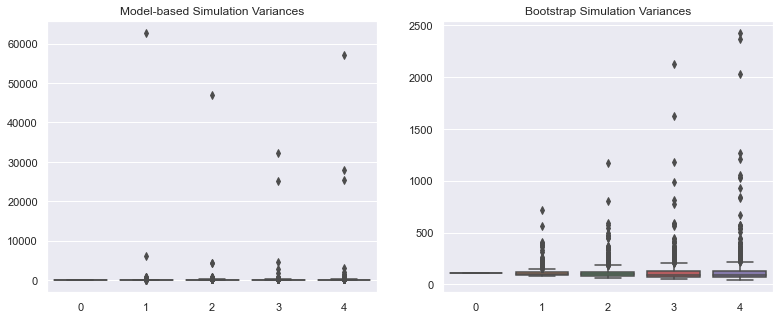

In [52]:
# Plot Simulation Variances
fig, axes = plt.subplots(1, 2, figsize=(13,5))

sns.boxplot(data=sim.variances[-1], ax=axes[0])
sns.boxplot(data=bs.variances[-1], ax=axes[1])

axes[0].set_title('Model-based Simulation Variances')
axes[1].set_title('Bootstrap Simulation Variances')

plt.show()

In [53]:
am = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')
res = am.fit(disp='off', last_obs='2018-01-01')

In [54]:
forecasts = res.forecast(start='2019-01-01')
cond_mean = forecasts.mean['2019':]
cond_var = forecasts.variance['2019':]
q = am.distribution.ppf([0.01, 0.05], res.params[5])
print(q)

[-2.61129928 -1.34378354]


In [55]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

1%          5%
count  268.000000  268.000000
mean    20.847144   10.443499
std      7.239453    3.725447
min      9.016268    4.355290
25%     15.694059    7.791703
50%     19.440739    9.719758
75%     25.677287   12.929107
max     44.601395   22.667517

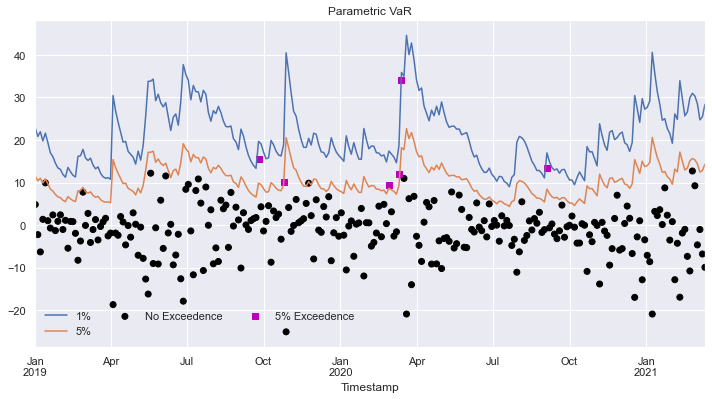

In [56]:
ax = value_at_risk.plot(legend=False, figsize=(12,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

rets_2019 = bitcoin_data.Return['2019':]
rets_2019.name = 'BTCUSD Return'

c = []
for idx in value_at_risk.index:
    if rets_2019[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2019[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')

labels = {
    
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}

markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}

for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2019.index[sel],
        -rets_2019.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.set_title('Parametric VaR')
ax.legend(frameon=False, ncol=3)

plt.show()

In [57]:
# Obtain model estimated residuals and volatility
gm_resid = res.resid
gm_std = res.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Obtain the empirical quantiles
q = gm_std_resid.quantile([.01, .05])
print(q)

0.01   -2.602521
0.05   -1.288227
dtype: float64


In [58]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q.values[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

1%          5%
count  268.000000  268.000000
mean    20.775096    9.987492
std      7.215117    3.571423
min      8.983990    4.150992
25%     15.639333    7.445332
50%     19.373418    9.293673
75%     25.589003   12.370336
max     44.449497   21.706124

In [59]:
ax = value_at_risk.plot(legend=False, figsize=(12,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

rets_2019 = bitcoin_data.Return['2019':]
rets_2019.name = 'BTCUSD Return'

c = []
for idx in value_at_risk.index:
    if rets_2019[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2019[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2019.index[sel],
        -rets_2019.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.set_title('Filtered Historical Simulation VaR')
ax.legend(frameon=False, ncol=3)

plt.show()

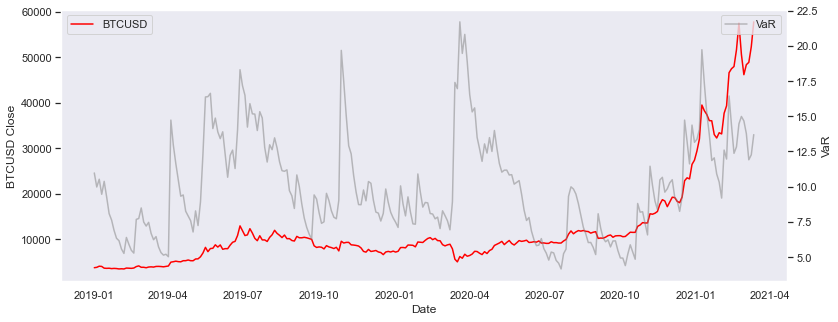

In [60]:
fig, ax1 = plt.subplots(figsize=(13, 5))
ax2 = ax1.twinx()

ax1.grid(False)
ax2.grid(False)

ax1.plot(bitcoin_data.loc[value_at_risk.index[0]:].index, bitcoin_data.loc[value_at_risk.index[0]:].Close, 
         color='red', label='BTCUSD')
ax2.plot(value_at_risk['5%'].index, value_at_risk['5%'], color='grey', label='VaR', alpha=0.5)

ax1.set_xlabel('Date')
ax1.set_ylabel('BTCUSD Close')
ax2.set_ylabel('VaR')

ax1.legend(loc='upper left')
ax2.legend()

plt.show()

In [61]:
start = pd.Timestamp('2012-01-01')
end = pd.Timestamp('2020-01-06')

sp_data = web.DataReader('SPY', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

sp_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2015 entries, 2012-01-03 to 2020-01-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2015 non-null   float64
 1   Low        2015 non-null   float64
 2   Open       2015 non-null   float64
 3   Close      2015 non-null   float64
 4   Volume     2015 non-null   float64
 5   Adj Close  2015 non-null   float64
dtypes: float64(6)
memory usage: 110.2 KB


In [62]:
tmf_data = web.DataReader('TMF', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

tmf_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2015 entries, 2012-01-03 to 2020-01-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2015 non-null   float64
 1   Low        2015 non-null   float64
 2   Open       2015 non-null   float64
 3   Close      2015 non-null   float64
 4   Volume     2015 non-null   float64
 5   Adj Close  2015 non-null   float64
dtypes: float64(6)
memory usage: 110.2 KB


In [63]:
upro_data = web.DataReader('UPRO', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

upro_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2015 entries, 2012-01-03 to 2020-01-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2015 non-null   float64
 1   Low        2015 non-null   float64
 2   Open       2015 non-null   float64
 3   Close      2015 non-null   float64
 4   Volume     2015 non-null   float64
 5   Adj Close  2015 non-null   float64
dtypes: float64(6)
memory usage: 110.2 KB


<AxesSubplot:xlabel='Date'>

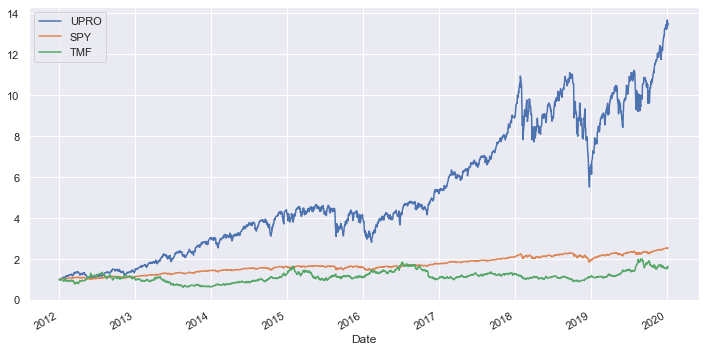

In [64]:
prices = pd.DataFrame({'UPRO': upro_data['Close'],
                       'SPY': sp_data['Close'],
                       'TMF': tmf_data['Close']})

prices.div(prices.iloc[0,:]).plot(figsize=(12, 6))# Normalize Prices 

In [65]:
tmf_data['Return'] = np.log(tmf_data['Close']).diff().mul(100) # rescale to faciliate optimization
tmf_data = tmf_data.dropna()

upro_data['Return'] = np.log(upro_data['Close']).diff().mul(100) # rescale to faciliate optimization
upro_data = upro_data.dropna()

sp_data['Return'] = np.log(sp_data['Close']).diff().mul(100) # rescale to faciliate optimization
sp_data = sp_data.dropna()

In [66]:
sp_model = pm.auto_arima(sp_data['Return'],

d=0, # non-seasonal difference order
start_p=1, # initial guess for p
start_q=1, # initial guess for q
max_p=4, # max value of p to test
max_q=4, # max value of q to test                        
                    
seasonal=False, # is the time series seasonal
                    
information_criterion='bic', # used to select best model
trace=True, # print results whilst training
error_action='ignore', # ignore orders that don't work
stepwise=True, # apply intelligent order search
                        
)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=4897.478, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=4886.833, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=4894.106, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=4894.084, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=4887.904, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.587 seconds


In [67]:
print(sp_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2014
Model:                        SARIMAX   Log Likelihood               -2439.613
Date:                Fri, 12 Mar 2021   AIC                           4881.225
Time:                        15:03:33   BIC                           4886.833
Sample:                             0   HQIC                          4883.283
                               - 2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6602      0.013     51.238      0.000       0.635       0.685
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):              1010.05
Prob(Q):                              0.47   Pr

In [68]:
tmf_model = pm.auto_arima(tmf_data['Return'],

d=0, # non-seasonal difference order
start_p=1, # initial guess for p
start_q=1, # initial guess for q
max_p=4, # max value of p to test
max_q=4, # max value of q to test                        
                    
seasonal=False, # is the time series seasonal
                    
information_criterion='bic', # used to select best model
trace=True, # print results whilst training
error_action='ignore', # ignore orders that don't work
stepwise=True, # apply intelligent order search
                        
)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=9098.437, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=9091.384, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=9097.146, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=9097.219, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=9098.782, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.481 seconds


In [69]:
print(tmf_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2014
Model:                        SARIMAX   Log Likelihood               -4541.888
Date:                Fri, 12 Mar 2021   AIC                           9085.776
Time:                        15:04:16   BIC                           9091.384
Sample:                             0   HQIC                          9087.834
                               - 2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.3251      0.137     38.969      0.000       5.057       5.593
Ljung-Box (L1) (Q):                   1.86   Jarque-Bera (JB):               133.29
Prob(Q):                              0.17   Pr

In [70]:
upro_model = pm.auto_arima(upro_data['Return'],

d=0, # non-seasonal difference order
start_p=1, # initial guess for p
start_q=1, # initial guess for q
max_p=4, # max value of p to test
max_q=4, # max value of q to test                        
                    
seasonal=False, # is the time series seasonal
                    
information_criterion='bic', # used to select best model
trace=True, # print results whilst training
error_action='ignore', # ignore orders that don't work
stepwise=True, # apply intelligent order search
                        
)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=9302.350, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=9290.538, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=9297.996, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=9297.987, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=9292.408, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.511 seconds


In [71]:
print(upro_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2014
Model:                        SARIMAX   Log Likelihood               -4641.465
Date:                Fri, 12 Mar 2021   AIC                           9284.930
Time:                        15:05:08   BIC                           9290.538
Sample:                             0   HQIC                          9286.988
                               - 2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.8786      0.115     51.315      0.000       5.654       6.103
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):              1069.17
Prob(Q):                              0.61   Pr

In [72]:
_arma_sp = sm.tsa.SARIMAX(endog=sp_data['Return'],order=(0, 0, 0))
_sp_model_result = _arma_sp.fit()

egarch_sp = arch_model(_sp_model_result.resid, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't', mean = 'zero')
sp_gm_result = egarch_sp.fit(disp = 'off')
print(sp_gm_result.summary())

                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -2103.72
Distribution:      Standardized Student's t   AIC:                           4217.44
Method:                  Maximum Likelihood   BIC:                           4245.48
                                              No. Observations:                 2014
Date:                      Fri, Mar 12 2021   Df Residuals:                     2014
Time:                              15:05:27   Df Model:                            0
                               Volatility Model                               
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

In [73]:
_arma_tmf = sm.tsa.SARIMAX(endog=tmf_data['Return'],order=(0, 0, 0))
_tmf_model_result = _arma_tmf.fit()

egarch_tmf = arch_model(_tmf_model_result.resid, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't', mean = 'zero')
tmf_gm_result = egarch_tmf.fit(disp = 'off')
print(tmf_gm_result.summary())

                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -4477.57
Distribution:      Standardized Student's t   AIC:                           8965.14
Method:                  Maximum Likelihood   BIC:                           8993.18
                                              No. Observations:                 2014
Date:                      Fri, Mar 12 2021   Df Residuals:                     2014
Time:                              15:05:48   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

In [74]:
_arma_upro = sm.tsa.SARIMAX(endog=upro_data['Return'],order=(0, 0, 0))
_upro_model_result = _arma_upro.fit()

egarch_upro = arch_model(_upro_model_result.resid, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't', mean = 'zero')
upro_gm_result = egarch_upro.fit(disp = 'off')
print(upro_gm_result.summary())

                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -4285.39
Distribution:      Standardized Student's t   AIC:                           8580.78
Method:                  Maximum Likelihood   BIC:                           8608.82
                                              No. Observations:                 2014
Date:                      Fri, Mar 12 2021   Df Residuals:                     2014
Time:                              15:06:11   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega     

In [75]:
# Step 1: Fit GARCH models and obtain volatility for each return series
vol_tmf = tmf_gm_result.conditional_volatility
vol_upro = upro_gm_result.conditional_volatility

In [76]:
# Step 2: Compute standardized residuals from the tted GARCH models
resid_tmf = tmf_gm_result.resid/vol_tmf
resid_upro = upro_gm_result.resid/vol_upro

In [77]:
# Step 3: Compute ρ as simple correlation of standardized residuals
corr = np.corrcoef(resid_tmf, resid_upro)[0,1]

In [78]:
# Step 4: Compute GARCH covariance by multiplying the correlation and volatility.
covariance = corr * vol_tmf * vol_upro

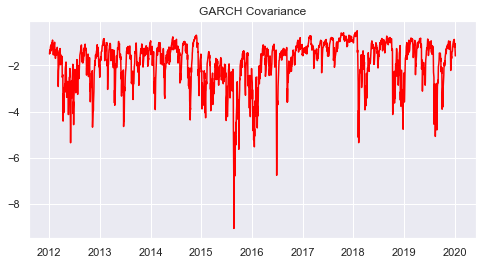

In [79]:
# Plot the data
plt.plot(covariance, color = 'red')
plt.title('GARCH Covariance')
plt.show()

In [80]:
data = {}
for perc in range(100):
    daily = (1 - perc / 100) * tmf_data["Return"] + (perc / 100) * upro_data["Return"]
    data[perc] = daily.mean() / daily.std() * (252 ** 0.5)
    
sx = pd.Series(data)
s = pd.DataFrame(sx, index=sx.index)
ax = s.plot(title="UPRO/TMF allocation vs Sharpe")
ax.set_ylabel("Sharpe Ratio")
ax.set_xlabel("Percent Portfolio UPRO")
plt.show()

tmf_w = 100 - s.idxmax()[0]
print('Optimal UPRO Weight =', s.idxmax()[0])
print('Optimal TNF Weight =', tmf_w)
print('Optimal Sharpe Ratio =', s.max()[0])

Optimal UPRO Weight = 64
Optimal TNF Weight = 36
Optimal Sharpe Ratio = 0.995746865307354


In [81]:
# Define weights
Wa1 = 0.64
Wa2 = 0.36

Wb1 = 0.49
Wb2 = 1 - Wb1

# Calculate individual returns variance
variance_upro = np.var(upro_data['Return'])
variance_tmf = np.var(tmf_data['Return'])

# Calculate portfolio variance
portvar_a = Wa1**2 * variance_tmf + Wa2**2 * variance_upro + 2*Wa1*Wa2*covariance
portvar_b = Wb1**2 * variance_tmf + Wb2**2 * variance_upro + 2*Wb1*Wb2*covariance

# Plot the data
plt.plot(portvar_a, color = 'red', label = 'Portfolio a')
plt.plot(portvar_b, color = 'deepskyblue', label = 'Portfolio b')
plt.title('Covariance')
plt.legend(loc = 'best')
plt.show()

In [82]:
# 1). Compute correlation between S&P500 and stock
resid_stock = tmf_gm_result.resid / tmf_gm_result.conditional_volatility
resid_sp500 = sp_gm_result.resid / sp_gm_result.conditional_volatility

correlation = np.corrcoef(resid_stock, resid_sp500)[0, 1]

# 2). Compute dynamic Beta for the stock
stock_beta = correlation * (tmf_gm_result.conditional_volatility / sp_gm_result.conditional_volatility)

In [83]:
# Plot the Beta
plt.title('TMF Stock Beta')
plt.plot(stock_beta)
plt.show()